## Fake Job Classifier

The dataset used is the Employment Scam Aegean Dataset (EMSCAD) dataset which is provided publicly by the University of the Aegean Laboratory of Information & Communication Systems Security. This dataset contains 17,880 real-life job postings in which 17,014 are real and 866 are fake. This dataset is further processed and uploaded on the Kaggle and is available publicly. 

In [58]:
#Importing Libraries
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.svm import SVC

In [59]:
#Reading dataset
data = pd.read_csv('/content/fake_job_postings.csv')
df2 = data.copy()
data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


### Exploratory Data Analysis

In [60]:
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [61]:

#Fill NaN values with blank space
data.fillna(' ', inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,fraudulent,title
0,0,17014
1,1,866


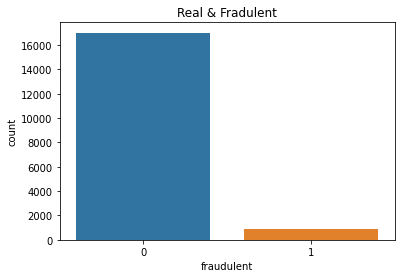

In [62]:
sns.countplot(data.fraudulent).set_title('Real & Fradulent')
data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

Text(0.5, 0, 'Countries')

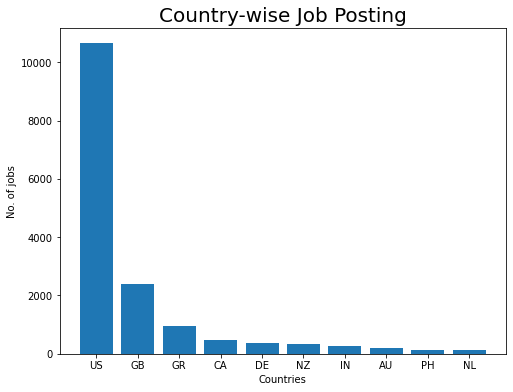

In [63]:
#Visualize job postings by countries
def split(location):
    l = location.split(',')
    return l[0]

data['country'] = data.location.apply(split)

country = dict(data.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

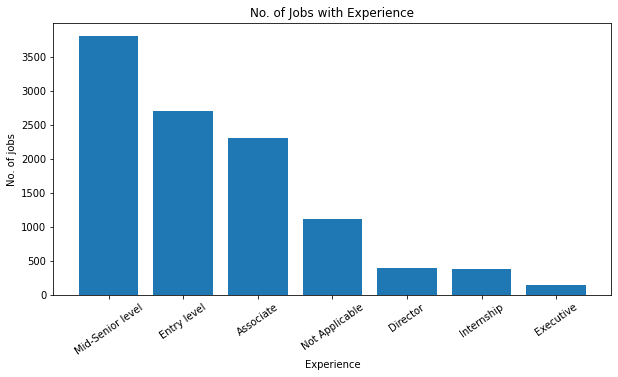

In [64]:
#Visualize the required experiences in the jobs
experience = dict(data.required_experience.value_counts())
del experience[' ']
plt.figure(figsize=(10,5))
plt.bar(experience.keys(), experience.values())
plt.title('No. of Jobs with Experience')
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

In [65]:
#Most frequent jobs
print(data.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [66]:
#Most frequent requirements or qualifications
print(data.requirements.value_counts()[:10])

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              2695
University degree required. TEFL / TESOL / CELTA or teaching experience preferred but not necessaryCanada/US passport holders only                                                                                                                                                   

<BarContainer object of 5 artists>

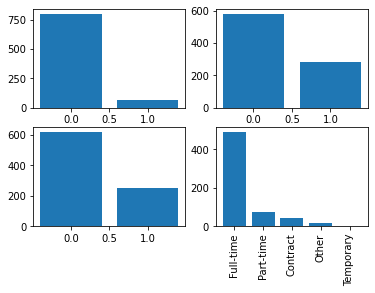

In [67]:
#Filtering out the fraudulent jobs
fraudulent_data = data[data['fraudulent']==1]

#Distribution of fraudulent jobs 
data3 = dict(fraudulent_data.telecommuting.value_counts())
data4 = dict(fraudulent_data.has_company_logo.value_counts())
data5 = dict(fraudulent_data.has_questions.value_counts())
data6 = dict(fraudulent_data.employment_type.value_counts())
data7 = dict(fraudulent_data.industry.value_counts())
del data6[' ']
del data7[' ']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.bar(data3.keys(), data3.values())
ax2.bar(data4.keys(), data4.values())
ax3.bar(data5.keys(), data5.values())
plt.xticks(rotation='90')
ax4.bar(data6.keys(), data6.values())


As seen from the graph, full-time jobs are clearly more succeptible to fraud than part-time or contract based jobs.

<BarContainer object of 62 artists>

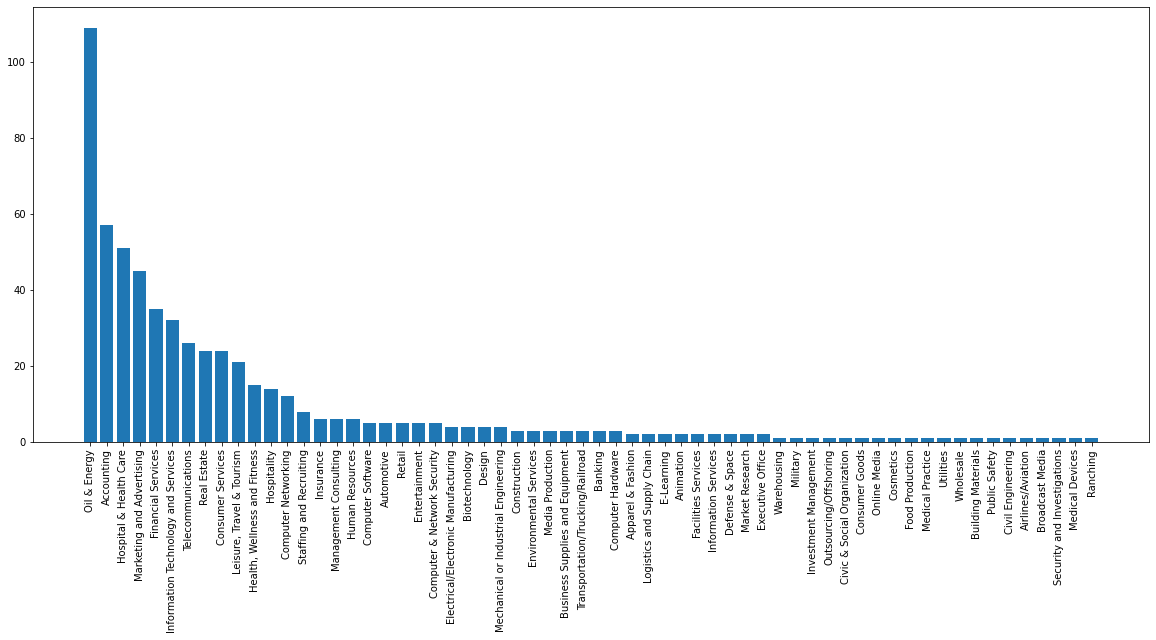

In [68]:
plt.figure(figsize=(20,8))
plt.xticks(rotation='90')
plt.bar(data7.keys(), data7.values())

The high-paying, high-risk jobs in the industries like Oil & Energy, Accounting, Health Care, Advertising, Finance seem to attract scammers more.

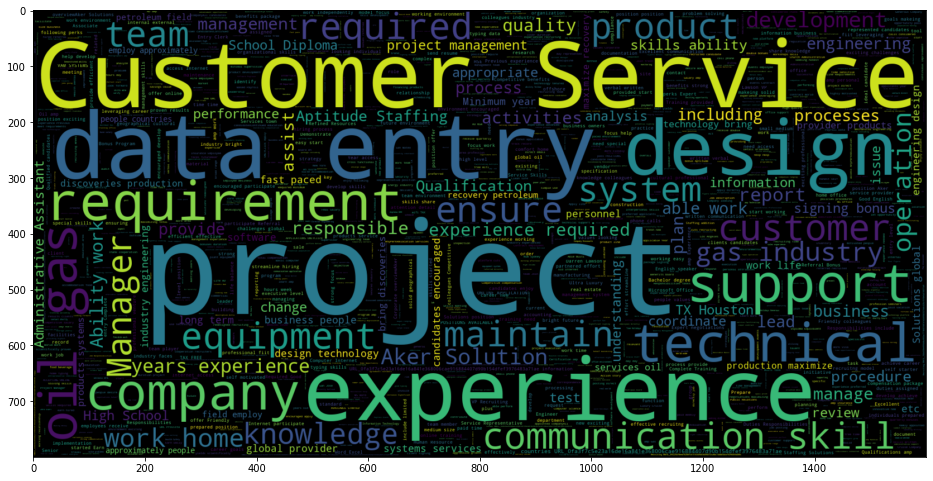

In [69]:
data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']

fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text

#Fraudulent jobs word cloud
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

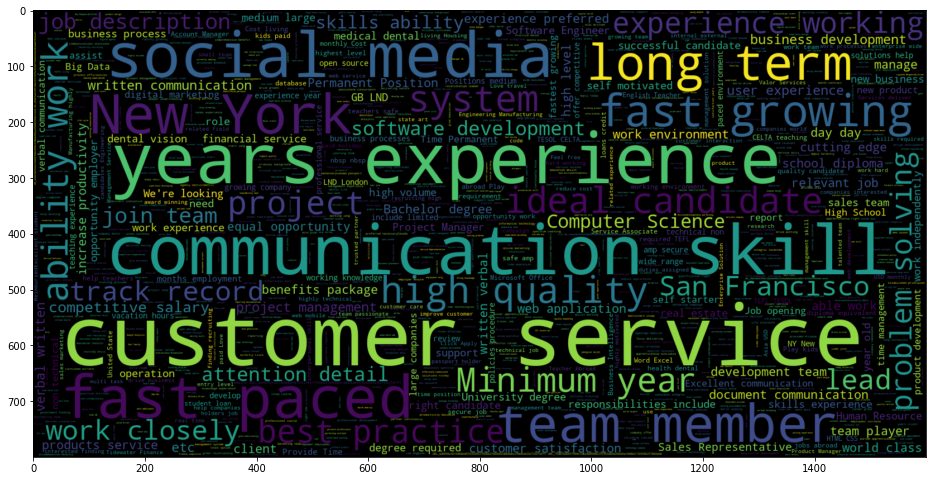

In [14]:
#Actual jobs wordcloud
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

From the two word clouds, we can see some differences. Fake jobs focus on words like data entry, equipment, oil & gas, design, technical, product etc. which are different from the words used to describe real job postings.

### Data Cleaning & Feature Engineering

In [70]:
#Dropping columns not useful for analysis
df2.drop(['salary_range', 'job_id', 'department', 'benefits'], axis = 1, inplace = True)

In [71]:
df2 = df2.sort_values('title').reset_index(drop = True)

df2['employment_type'] = df2['employment_type'].bfill(axis=0)
df2['required_experience'] = df2['required_experience'].bfill(axis=0)
df2['required_education'] = df2['required_education'].bfill(axis = 0)
df2['industry'] = df2['industry'].bfill(axis=0)
df2['function'] = df2['function'].bfill(axis=0)

df2 = df2[df2['description'].notna()]
df2 = df2.dropna(axis = 0, how = 'any')
df2 = df2.drop_duplicates(keep = 'first')

df2['description'] = df2['description'] + ' ' + df2['requirements'] + ' ' + df2['company_profile']
df2.drop(['company_profile', 'requirements'], axis = 1, inplace = True)


df2['country_code'] = df2['location'].str.split(',', expand=True)[0]
df2['city'] = df2['location'].str.split(',', expand = True)[2]

df2.dropna(inplace = True)
df2.shape

(12232, 14)

In [72]:
import pycountry
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
def country(df):
    if df['country_code'] in list_alpha_2:
        return pycountry.countries.get(alpha_2 = df['country_code']).name
df2['country_name'] = df2.apply(country, axis = 1)

In [73]:
df2.drop(['location', 'country_code'], axis = 1, inplace = True)

### Natural Language Processing

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
pd.set_option('display.max_columns', None)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
import string
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
import string 
import re
import spacy 
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

In [75]:
import spacy
nlp = spacy.load('en_core_web_sm')
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
punctuations = string.punctuation
def cleanup_text(docs, logging = False):
    texts = []
    for doc in docs:
        doc = nlp(doc, disable = ['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [76]:
STOPLIST = set(stopwords + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ")
def tokenizetext(sample):
    text = sample.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    tokens = parser(text)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens
vectorizer = CountVectorizer(tokenizer = tokenizetext, ngram_range = (1,3), min_df = 0.06)
vectorizer_features = vectorizer.fit_transform(df2['description'])

vectorized_df = pd.DataFrame(vectorizer_features.todense(), columns = vectorizer.get_feature_names())
df_vectorized = pd.concat([df2, vectorized_df], axis = 1)
df_vectorized.drop('description', axis = 1, inplace = True)
df_vectorized.dropna(inplace=True)

columns_to_1_hot = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

for column in columns_to_1_hot:
    encoded = pd.get_dummies(df_vectorized[column])
    df_vectorized = pd.concat([df_vectorized, encoded], axis = 1)
    
columns_to_1_hot += ['title', 'city', 'country_name']
df_vectorized.drop(columns_to_1_hot, axis = 1, inplace = True)

In [85]:
target = df_vectorized['fraudulent']
features = df_vectorized.drop('fraudulent', axis = 1)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train.ravel())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(14854, 812)
(1651, 812)
(14854,)
(1651,)


#### Classification using ML libraries

In [86]:
Model_Name = []
Model_Score = []
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

#### Logistic Regression

In [87]:

log_reg = LogisticRegression()
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty_options = ['l1', 'l2']

param_grid = dict(C = c_values, penalty = penalty_options)
grid_tfidf = GridSearchCV(log_reg, param_grid = param_grid, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose=1)
grid_tfidf.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [88]:
grid_tfidf.best_score_

0.9873552676305215

In [89]:
grid_tfidf.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [90]:
log_reg_pred = grid_tfidf.predict(X_test)

In [91]:
roc_auc_score(y_test, log_reg_pred)

0.9709443099273607

In [92]:
print (classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       826
         1.0       0.95      1.00      0.97       825

    accuracy                           0.97      1651
   macro avg       0.97      0.97      0.97      1651
weighted avg       0.97      0.97      0.97      1651



In [93]:
Model_Name.append('Logistic_Regression')
Model_Score.append(round(roc_auc_score(y_test, log_reg_pred), 4))

#### KNN

In [94]:
knn = KNeighborsClassifier()
k_range = list(np.arange(2, 23, 2))
param_grid_knn = dict(n_neighbors = k_range)
print (param_grid_knn)

{'n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]}


In [95]:
grid_knn = GridSearchCV(knn, param_grid_knn, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)
grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 25.6min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                         22]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [96]:
grid_knn.best_score_

0.9525814378591017

In [97]:
grid_knn.best_params_

{'n_neighbors': 22}

In [98]:
knn_pred = grid_knn.predict(X_test)
print (roc_auc_score(y_test, knn_pred))
print (classification_report(y_test, knn_pred))

0.660411622276029
              precision    recall  f1-score   support

         0.0       1.00      0.32      0.49       826
         1.0       0.60      1.00      0.75       825

    accuracy                           0.66      1651
   macro avg       0.80      0.66      0.62      1651
weighted avg       0.80      0.66      0.62      1651



In [99]:
Model_Name.append('KNN')
Model_Score.append(round(roc_auc_score(y_test, knn_pred), 4))

#### SVM

In [100]:
svc = SVC()
kernel = ['linear', 'rbf']
param_grid_knn = dict(kernel = kernel)
print (param_grid_knn)

{'kernel': ['linear', 'rbf']}


In [101]:
grid_svc = GridSearchCV(svc, param_grid_knn, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
grid_svc.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 15.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'kernel': ['linear', 'rbf']}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='roc_auc',
             verbose=2)

In [102]:
grid_svc.best_score_

0.9988485220746768

In [103]:
grid_svc.best_params_

{'kernel': 'rbf'}

In [104]:
svc_pred = grid_svc.predict(X_test)
print (roc_auc_score(y_test, svc_pred))
print (classification_report(y_test, svc_pred))

0.978813559322034
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       826
         1.0       0.96      1.00      0.98       825

    accuracy                           0.98      1651
   macro avg       0.98      0.98      0.98      1651
weighted avg       0.98      0.98      0.98      1651



In [105]:
Model_Name.append('SVC')
Model_Score.append(round(roc_auc_score(y_test, svc_pred), 4))

#### Random Forest

In [106]:
rf = RandomForestClassifier()
n_estimators_range = [1, 2, 4, 8, 16, 32, 64, 100, 200]
param_grid_rf = dict(n_estimators = n_estimators_range)
grid_rf = GridSearchCV(rf, param_grid_rf, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

In [107]:
grid_rf.fit(X_train, y_train)
print (grid_rf.best_score_)
print (grid_rf.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.4min finished


0.9997621916291571
{'n_estimators': 100}


In [108]:
rf_pred = grid_rf.predict(X_test)
print (roc_auc_score(y_test, rf_pred))
print (classification_report(y_test, rf_pred))

0.9951515151515151
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       826
         1.0       1.00      0.99      1.00       825

    accuracy                           1.00      1651
   macro avg       1.00      1.00      1.00      1651
weighted avg       1.00      1.00      1.00      1651



In [109]:
Model_Name.append('Random_Forest')
Model_Score.append(round(roc_auc_score(y_test, rf_pred), 4))

#### Multi-layer perceptron

In [110]:
mlp = MLPClassifier(solver = 'adam', activation = 'relu', hidden_layer_sizes = (100, 50, 30), max_iter = 1000)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [111]:
mlp_pred = mlp.predict(X_test)
print (roc_auc_score(y_test, mlp_pred))
print (classification_report(y_test, mlp_pred))

0.9939459975053195
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       826
         1.0       0.99      1.00      0.99       825

    accuracy                           0.99      1651
   macro avg       0.99      0.99      0.99      1651
weighted avg       0.99      0.99      0.99      1651



In [112]:
Model_Name.append('MLP-NN (adam)')
Model_Score.append(round(roc_auc_score(y_test, mlp_pred), 4))

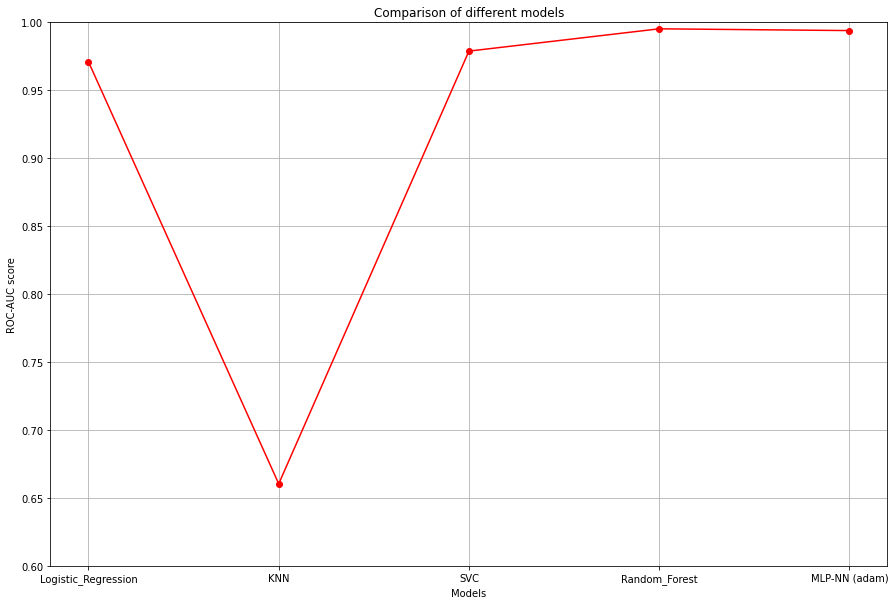

In [115]:
plt.figure(figsize = (15, 10))
plt.plot(Model_Name,Model_Score, marker = 'o', color = 'red')
plt.title('Comparison of different models')
plt.xlabel('Models')
plt.ylabel('ROC-AUC score')
plt.ylim(0.6, 1.0)
plt.grid()
plt.savefig('Model_compare.jpeg')
plt.show()

Not surprisingly, Random Forest and MLP work best for this classification with f-1 score of 0.99